In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
from optuna.integration import XGBoostPruningCallback
import warnings
warnings.filterwarnings('ignore')

/Users/heyueqi/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 1. Load Processed Data (feature engineering; 24h; aggregation)

In [2]:
TIME_WINDOW_IN_HOUR = 72
df_agg = pd.read_csv(f'../../data/mimic_dataset_{TIME_WINDOW_IN_HOUR}h_aggregated.csv')
df_agg.head()

,gender,age,elixhauser,re_admission,Height_cm,Weight_kg,mechvent_mean,mechvent_max,extubated_mean,extubated_max,...,SIRS_min,SIRS_max,SIRS_std,SIRS_last,time_to_discharge_mean,time_to_discharge_min,time_to_discharge_max,time_to_discharge_std,time_to_discharge_last,died_in_hosp
0,1,82,3,0,175.00,80.0,0.631579,1,0.052632,1,...,1,3,0.696692,1,273600.0,273600,273600,0.0,273600,0
1,1,30,7,0,172.72,56.8,0.000000,0,0.000000,0,...,2,4,0.333333,3,273600.0,273600,273600,0.0,273600,0
2,1,47,1,0,167.64,62.8,0.368421,1,0.157895,1,...,1,4,0.768533,2,273600.0,273600,273600,0.0,273600,0
3,1,43,9,1,172.72,66.6,1.000000,1,0.000000,0,...,0,4,1.228321,1,273600.0,273600,273600,0.0,273600,0
4,1,53,8,0,155.00,47.5,1.000000,1,0.000000,0,...,1,4,0.653376,3,273600.0,273600,273600,0.0,273600,1


In [3]:
df_agg['died_in_hosp'].sum()/df_agg.shape[0]

0.21005706134094151

## 2. Define X and y

In [4]:
target_col = 'died_in_hosp'
y = df_agg[target_col].astype(int)
X = df_agg.drop(columns=[target_col])

## 3. Data Splitting  
- Divide the dataset into the training set and the test set, with an 80/20 ratio.
- To ensure that the proportion of deceased/survived patients in the training set and the test set is consistent with the original data, `stratified sampling` is adopted.

In [5]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_size, 
    random_state=42, 
    stratify=y
)

print(f"Size of the training set: {X_train.shape}")
print(f"Size of the testing set: {X_test.shape}")
print(f"Training set mortality rate: {y_train.mean():.3f}")
print(f"Testing set mortality rate: {y_test.mean():.3f}")

Size of the training set: (2243, 330)
Size of the testing set: (561, 330)
Training set mortality rate: 0.210
Testing set mortality rate: 0.210


## 4. Missing Value Imputation

- For missing values, the **MICE (Multiple Imputation by Chained Equations)** method is used. This approach iteratively predicts missing values for each feature using other features in the dataset, making it more robust and accurate compared to simple imputation methods like mean or median.

- The imputation model is fitted only on the training set and then applied to both the training and testing sets to prevent data leakage.

- MICE is particularly effective when there are complex relationships between features or when multiple features have missing values.

In [6]:
print(f"Proportion of missing values:")
missing_proportion = (X.isnull().sum()/X.shape[0]).sort_values(ascending=False) 
print(missing_proportion)

Proportion of missing values:
ETCO2_std                 0.044936
ETCO2_min                 0.044579
ETCO2_max                 0.044579
ETCO2_last                0.044579
ETCO2_mean                0.044579
                            ...   
PAWpeak_last              0.000000
PAWpeak_std               0.000000
PAWpeak_max               0.000000
PAWpeak_min               0.000000
time_to_discharge_last    0.000000
Length: 330, dtype: float64


In [7]:
imputer = IterativeImputer(max_iter=10, random_state=42)

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

## 5. Feature Scaling    
    
XGBoost does not require feature scaling because it is a tree-based model.   

## 6. XGBoost Model Training and Hyperparameter Tuning

In [8]:
# calculate the category weights to handle imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Category weight: {scale_pos_weight:.2f}")

Category weight: 3.76


In [9]:
def objective(trial):
    """
    Optuna objective function for XGBoost hyperparameter optimization.
    """
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',  # better for imbalanced data
        'tree_method': 'hist',
        'scale_pos_weight': scale_pos_weight,  # handle imbalanced data
        'random_state': 42,
        
        # Hyperparameter search space
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), 
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1.0),  # reduce overfitting
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2.0),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2.0),  # L2 regularization
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 5),  # helpful for imbalanced data
    }
    
    # use StratifiedKFold for cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores_auc = []
    cv_scores_aucpr = []  # AUCPR is more relevant for imbalanced data
    train_scores = []  # monitor training performance for overfitting analysis
    
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_imputed, y_train)):
        X_fold_train = X_train_imputed[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train_imputed[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params)
        
        model.fit(
            X_fold_train, y_fold_train,
            eval_set=[(X_fold_train, y_fold_train), (X_fold_val, y_fold_val)],
            verbose=False
        )
        
        # calculate metrics on training and validation sets
        y_train_proba = model.predict_proba(X_fold_train)[:, 1]
        y_val_proba = model.predict_proba(X_fold_val)[:, 1]
        
        train_auc = roc_auc_score(y_fold_train, y_train_proba)
        val_auc = roc_auc_score(y_fold_val, y_val_proba)
        val_aucpr = average_precision_score(y_fold_val, y_val_proba)  # AUPR is main metric, better for imbalanced data
        
        train_scores.append(train_auc)
        cv_scores_auc.append(val_auc)
        cv_scores_aucpr.append(val_aucpr)
        
        # Optuna pruning: if the intermediate AUPR is not promising, prune the trial
        trial.report(val_aucpr, fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    mean_cv_auc = np.mean(cv_scores_auc)
    mean_cv_aucpr = np.mean(cv_scores_aucpr)  # main evaluation metric
    mean_train_score = np.mean(train_scores)
    
    # overfitting penalty
    overfitting_penalty = abs(mean_train_score - mean_cv_auc)
    if overfitting_penalty > 0.05:  
        mean_cv_aucpr -= overfitting_penalty * 0.5  
    
    trial.set_user_attr('mean_train_auc', mean_train_score)
    trial.set_user_attr('mean_val_auc', mean_cv_auc)
    trial.set_user_attr('mean_val_aucpr', mean_cv_aucpr)
    trial.set_user_attr('overfitting_gap', overfitting_penalty)
    
    return mean_cv_aucpr  

In [10]:
print("Starting hyperparameter optimization with Optuna...")
print("=" * 60)

# create study
study = optuna.create_study(
    direction='maximize',  # maximize AUCPR
    sampler=optuna.samplers.TPESampler(seed=42),  # use TPE sampler
    pruner=optuna.pruners.MedianPruner(  # median pruner
        n_startup_trials=10,  # first 10 trials no pruning
        n_warmup_steps=20,    # first 20 steps no pruning
        interval_steps=10     # check pruning every 10 steps
    )
)

study.optimize(objective, n_trials=100, show_progress_bar=True)

print("\nFinish.")
print("=" * 60)


[I 2025-11-07 09:08:40,474] A new study created in memory with name: no-name-a8349d35-081d-4f9f-a157-fd429d53b4ba


Starting hyperparameter optimization with Optuna...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-07 09:08:56,679] Trial 0 finished with value: 0.4228843344129623 and parameters: {'max_depth': 5, 'learning_rate': 0.2536999076681772, 'n_estimators': 800, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.05808361216819946, 'reg_alpha': 1.7323522915498704, 'reg_lambda': 1.2022300234864176, 'max_delta_step': 4}. Best is trial 0 with value: 0.4228843344129623.
[I 2025-11-07 09:09:10,637] Trial 1 finished with value: 0.43571224969747085 and parameters: {'max_depth': 3, 'learning_rate': 0.2708160864249968, 'n_estimators': 900, 'min_child_weight': 3, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'gamma': 0.3042422429595377, 'reg_alpha': 1.0495128632644757, 'reg_lambda': 0.8638900372842315, 'max_delta_step': 1}. Best is trial 1 with value: 0.43571224969747085.
[I 2025-11-07 09:09:37,116] Trial 2 finished with value: 0.46582102042282053 and parameters: {'max_depth': 6, 'learning_rate': 0.01607123851

In [11]:
best_params = study.best_params
best_score = study.best_value

print(f"\nbest trial AUC-PR: {best_score:.4f}")
print(f"\nbest hyperparameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

best_trial = study.best_trial
print(f"\nbest trial details:")
print(f"  training set average AUC: {best_trial.user_attrs['mean_train_auc']:.4f}")
print(f"  testing set average AUC: {best_trial.user_attrs['mean_val_auc']:.4f}")
print(f"  testing set average AUC-PR: {best_trial.user_attrs['mean_val_aucpr']:.4f}")
print(f"  overfitting gap: {best_trial.user_attrs['overfitting_gap']:.4f}")


best trial AUC-PR: 0.4917

best hyperparameters:
  max_depth: 3
  learning_rate: 0.012363292747601591
  n_estimators: 200
  min_child_weight: 5
  subsample: 0.8140699063161975
  colsample_bytree: 0.9705591301059493
  gamma: 0.42474224467462063
  reg_alpha: 1.2739213503838571
  reg_lambda: 0.09668785109513035
  max_delta_step: 4

best trial details:
  training set average AUC: 0.9298
  testing set average AUC: 0.8135
  testing set average AUC-PR: 0.4917
  overfitting gap: 0.1162


In [12]:
best_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr', 
    tree_method='hist',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    **best_params
)

best_xgb.fit(
    X_train_imputed, y_train,
    eval_set=[(X_train_imputed, y_train), (X_test_imputed, y_test)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9705591301059493, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, feature_weights=None,
              gamma=0.42474224467462063, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.012363292747601591,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=4, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

## 7. Model Evaluation

In [13]:
y_train_pred = best_xgb.predict(X_train_imputed)
y_test_pred = best_xgb.predict(X_test_imputed)
y_train_proba = best_xgb.predict_proba(X_train_imputed)[:, 1]
y_test_proba = best_xgb.predict_proba(X_test_imputed)[:, 1]

print("training set performance:")
print(f"  Accuracy: {best_xgb.score(X_train_imputed, y_train):.4f}")
train_auc = roc_auc_score(y_train, y_train_proba)
train_auprc = average_precision_score(y_train, y_train_proba)
print(f"  AUC-ROC: {train_auc:.4f}")
print(f"  AUPRC: {train_auprc:.4f}")
print(classification_report(y_train, y_train_pred))


print("testing set performance:")
test_auc = roc_auc_score(y_test, y_test_proba)
test_auprc = average_precision_score(y_test, y_test_proba)
print(f"  Accuracy: {best_xgb.score(X_test_imputed, y_test):.4f}")
print(f"  AUC-ROC: {test_auc:.4f}")
print(f"  AUPRC: {test_auprc:.4f}")
print(classification_report(y_test, y_test_pred))

print(f"\noverfitting gap (AUC): {train_auc - test_auc:.4f}")


training set performance:
  Accuracy: 0.8243
  AUC-ROC: 0.9147
  AUPRC: 0.7714
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1772
           1       0.56      0.82      0.66       471

    accuracy                           0.82      2243
   macro avg       0.75      0.82      0.77      2243
weighted avg       0.86      0.82      0.84      2243

testing set performance:
  Accuracy: 0.7487
  AUC-ROC: 0.7683
  AUPRC: 0.5458
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       443
           1       0.43      0.61      0.51       118

    accuracy                           0.75       561
   macro avg       0.66      0.70      0.67       561
weighted avg       0.79      0.75      0.76       561


overfitting gap (AUC): 0.1464


In [14]:
with open(f'../results/{TIME_WINDOW_IN_HOUR}h_xgboost_result.txt', 'w') as f:
    f.write(f'Sample size: {X.shape[0]}\n')
    f.write(f'\nBest model: {best_xgb}\n')


    f.write(f"\nTraining set performance:\n")
    f.write(f"    - Accuracy rate: {best_xgb.score(X_train_imputed, y_train):.4f}\n")
    f.write(f"    - AUC-ROC: {train_auc:.4f}\n")
    f.write(f"    - AUPRC: {train_auprc:.4f}\n")
    f.write(classification_report(y_train, y_train_pred))
    
    f.write(f"\nTesting set performance:\n")
    f.write(f"    - Accuracy rate: {best_xgb.score(X_test_imputed, y_test):.4f}\n")
    f.write(f"    - AUC-ROC: {test_auc:.4f}\n")
    f.write(f"    - AUPRC: {test_auprc:.4f}\n")
    f.write(classification_report(y_test, y_test_pred))
    
    f.write(f"\nOverfitting gap (AUC): {train_auc - test_auc:.4f}\n")
    
    cm = confusion_matrix(y_test, y_test_pred)
    f.write("\nConfusion matrix (test set):\n")
    f.write(np.array2string(cm))
    

## 8. Feature Importance Analysis

In [15]:
explainer = shap.TreeExplainer(best_xgb)

sample_size = len(X_test_imputed)
X_test_sample = X_test_imputed[:sample_size]
y_test_sample = y_test.iloc[:sample_size]

shap_values = explainer.shap_values(X_test_sample)

print(f"SHAP values shape: {shap_values.shape}")

feature_names = X.columns.tolist()
shap_df = pd.DataFrame(shap_values, columns=feature_names)

# SHAP Values
shap_importance = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

print(f"\nTop 20 features by Mean Absolute SHAP Value:")
for i, row in shap_importance.head(20).iterrows():
    print(f"{row['feature']:30s}: {row['mean_abs_shap']:.6f}")


SHAP values shape: (561, 330)

Top 20 features by Mean Absolute SHAP Value:
GCS_last                      : 0.170482
age                           : 0.157469
RASS_last                     : 0.152136
median_dose_vaso_last         : 0.119136
BUN_mean                      : 0.095993
FiO2_100_last                 : 0.086730
SOFA_mean                     : 0.084876
SOFA_last                     : 0.078057
SIRS_last                     : 0.071690
RASS_mean                     : 0.050476
BUN_last                      : 0.043344
Sodium_mean                   : 0.041091
MeanBP_last                   : 0.040579
output_step_mean              : 0.037580
O2flow_last                   : 0.032345
PT_last                       : 0.029472
Sodium_max                    : 0.026546
output_step_std               : 0.025510
DiaBP_last                    : 0.024310
PTT_mean                      : 0.024061


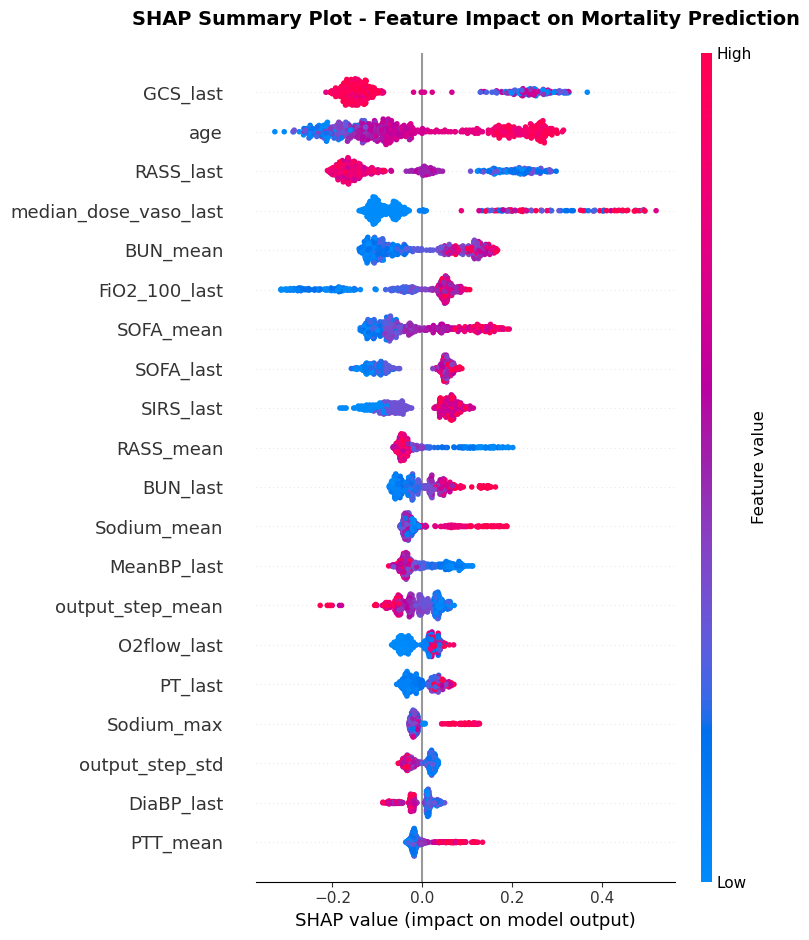

In [16]:
plt.figure(figsize=(14, 10))

shap.summary_plot(
    shap_values,                    # SHAP
    X_test_sample,                  # feature values (for color mapping)
    feature_names=feature_names,    
    max_display=20,                 
    show=False                    
)

plt.title('SHAP Summary Plot - Feature Impact on Mortality Prediction', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


## 9. Visualization

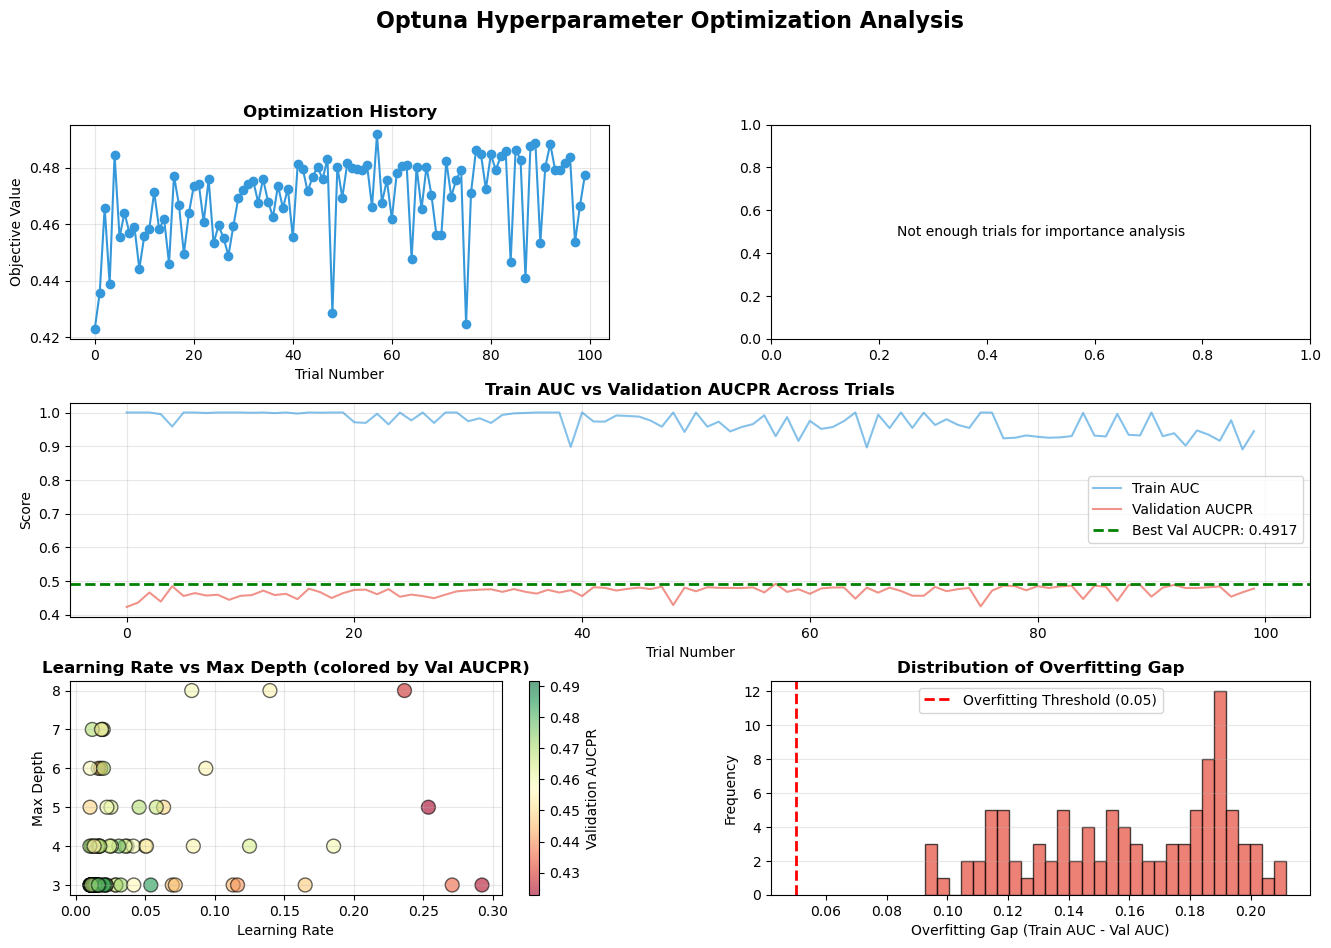

In [17]:
fig_optuna = plt.figure(figsize=(16, 10))
gs_optuna = fig_optuna.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. optimization history
ax1 = fig_optuna.add_subplot(gs_optuna[0, 0])
trial_numbers = [trial.number for trial in study.trials]
objective_values = [trial.value for trial in study.trials]

ax1.plot(trial_numbers, objective_values, marker='o', linestyle='-', color='#3498db')
ax1.set_title('Optimization History', fontsize=12, fontweight='bold')
ax1.set_xlabel('Trial Number')
ax1.set_ylabel('Objective Value')
ax1.grid(True, alpha=0.3)

# 2. hyperparameter importance
ax2 = fig_optuna.add_subplot(gs_optuna[0, 1])
try:
    optuna.visualization.matplotlib.plot_param_importances(study, ax=ax2)
    ax2.set_title('Hyperparameter Importance', fontsize=12, fontweight='bold')
except:
    ax2.text(0.5, 0.5, 'Not enough trials for importance analysis', 
             ha='center', va='center', transform=ax2.transAxes)

# 3. overfitting analysis
ax3 = fig_optuna.add_subplot(gs_optuna[1, :])
train_aucs = [trial.user_attrs.get('mean_train_auc', 0) for trial in study.trials]
val_aucprs = [trial.user_attrs.get('mean_val_aucpr', 0) for trial in study.trials]
trial_numbers = range(len(study.trials))

ax3.plot(trial_numbers, train_aucs, label='Train AUC', alpha=0.6, color='#3498db')
ax3.plot(trial_numbers, val_aucprs, label='Validation AUCPR', alpha=0.6, color='#e74c3c')
ax3.axhline(y=best_score, color='green', linestyle='--', 
            label=f'Best Val AUCPR: {best_score:.4f}', linewidth=2)
ax3.set_xlabel('Trial Number')
ax3.set_ylabel('Score')
ax3.set_title('Train AUC vs Validation AUCPR Across Trials', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Learning Rate vs Max Depth scatter plot
ax4 = fig_optuna.add_subplot(gs_optuna[2, 0])
lr_values = [trial.params.get('learning_rate', 0) for trial in study.trials]
depth_values = [trial.params.get('max_depth', 0) for trial in study.trials]
val_aucprs_scatter = [trial.user_attrs.get('mean_val_aucpr', 0) for trial in study.trials]
scatter = ax4.scatter(lr_values, depth_values, c=val_aucprs_scatter, 
                     cmap='RdYlGn', s=100, alpha=0.6, edgecolors='black')
ax4.set_xlabel('Learning Rate')
ax4.set_ylabel('Max Depth')
ax4.set_title('Learning Rate vs Max Depth (colored by Val AUCPR)', 
              fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax4, label='Validation AUCPR')
ax4.grid(True, alpha=0.3)

# 5. overfitting gap distribution
ax5 = fig_optuna.add_subplot(gs_optuna[2, 1])
overfitting_gaps = [trial.user_attrs.get('overfitting_gap', 0) for trial in study.trials]
ax5.hist(overfitting_gaps, bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
ax5.axvline(x=0.05, color='red', linestyle='--', 
            label='Overfitting Threshold (0.05)', linewidth=2)
ax5.set_xlabel('Overfitting Gap (Train AUC - Val AUC)')
ax5.set_ylabel('Frequency')
ax5.set_title('Distribution of Overfitting Gap', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

plt.suptitle('Optuna Hyperparameter Optimization Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()


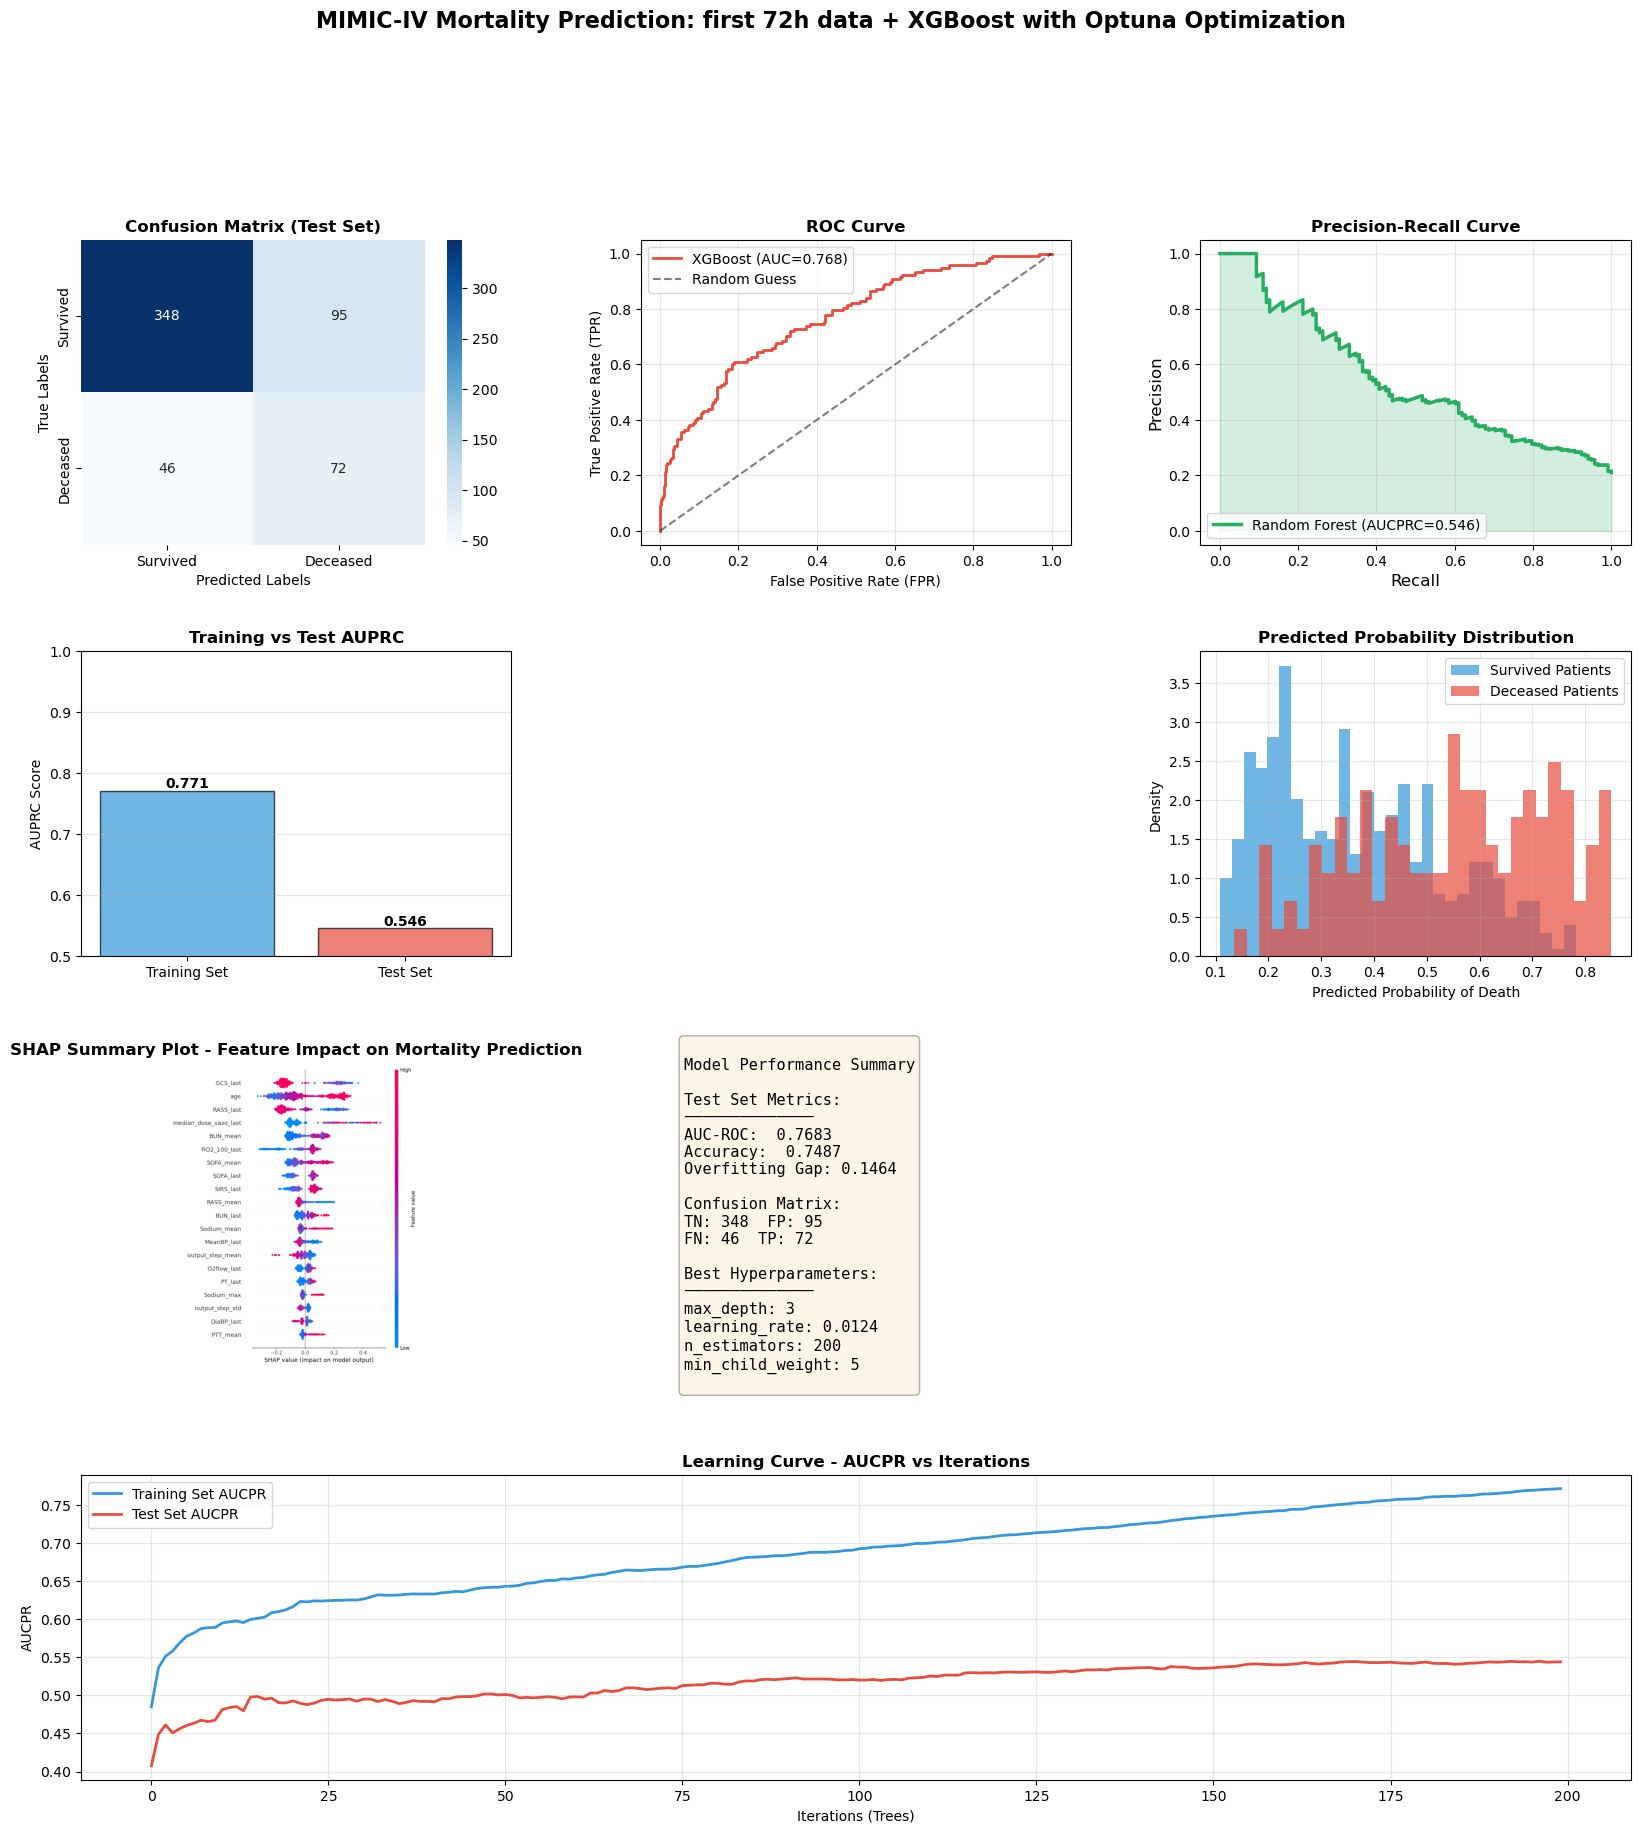

In [18]:
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Survived', 'Deceased'], 
            yticklabels=['Survived', 'Deceased'])
ax1.set_title('Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted Labels')
ax1.set_ylabel('True Labels')

# 2. ROC Curve
ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
ax2.plot(fpr, tpr, label=f'XGBoost (AUC={test_auc:.3f})', 
         linewidth=2, color='#e74c3c')
ax2.plot([0, 1], [0, 1], 'k--', label='Random Guess', alpha=0.5)
ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('True Positive Rate (TPR)')
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Precision-Recall Curve
ax3 = fig.add_subplot(gs[0, 2])
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
aucprc = average_precision_score(y_test, y_test_proba)

ax3.plot(recall, precision, label=f'Random Forest (AUCPRC={aucprc:.3f})', 
         linewidth=2.5, color='#27ae60')
ax3.fill_between(recall, precision, alpha=0.2, color='#27ae60')
ax3.set_xlabel('Recall', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax3.legend(loc='lower left', fontsize=10)
ax3.grid(True, alpha=0.3)



# 4. Training vs Test AUPRC Comparison
ax4 = fig.add_subplot(gs[1, 0])
scores = [train_auprc, test_auprc]
labels = ['Training Set', 'Test Set']
colors = ['#3498db', '#e74c3c']
bars = ax4.bar(labels, scores, color=colors, alpha=0.7, edgecolor='black')
ax4.set_ylabel('AUPRC Score')
ax4.set_title('Training vs Test AUPRC', fontsize=12, fontweight='bold')
ax4.set_ylim([0.5, 1.0])
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')



# 5. Predicted Probability Distribution
ax5 = fig.add_subplot(gs[1, 2])
ax5.hist(y_test_proba[y_test==0], bins=30, alpha=0.7, 
         label='Survived Patients', density=True, color='#3498db')
ax5.hist(y_test_proba[y_test==1], bins=30, alpha=0.7, 
         label='Deceased Patients', density=True, color='#e74c3c')
ax5.set_xlabel('Predicted Probability of Death')
ax5.set_ylabel('Density')
ax5.set_title('Predicted Probability Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)


# 5. SHAP Summary Plot
ax6 = fig.add_subplot(gs[2, 0])

shap_fig = plt.figure(figsize=(14, 10))

shap.summary_plot(
    shap_values,                   
    X_test_sample,                
    feature_names=feature_names,    
    max_display=20,                
    show=False                    
)

canvas = shap_fig.canvas
canvas.draw()
shap_image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
shap_image = shap_image.reshape(canvas.get_width_height()[::-1] + (3,))
plt.close(shap_fig)

ax6.imshow(shap_image)
ax6.axis('off') 
ax6.set_title('SHAP Summary Plot - Feature Impact on Mortality Prediction', 
              fontsize=12, fontweight='bold')


# 7. Performance Metrics Summary
test_acc = best_xgb.score(X_test_imputed, y_test)
ax7 = fig.add_subplot(gs[2, 1])
ax7.axis('off')
metrics_text = f"""
Model Performance Summary

Test Set Metrics:
──────────────
AUC-ROC:  {test_auc:.4f}
Accuracy:  {test_acc:.4f}
Overfitting Gap: {train_auc - test_auc:.4f}

Confusion Matrix:
TN: {cm[0,0]}  FP: {cm[0,1]}
FN: {cm[1,0]}  TP: {cm[1,1]}

Best Hyperparameters:
──────────────
max_depth: {best_params['max_depth']}
learning_rate: {best_params['learning_rate']:.4f}
n_estimators: {best_params['n_estimators']}
min_child_weight: {best_params['min_child_weight']}
"""
ax7.text(0.1, 0.5, metrics_text, fontsize=11, 
         verticalalignment='center', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# 8. Learning Curve
ax8 = fig.add_subplot(gs[3, :])
results = best_xgb.evals_result()
epochs = len(results['validation_0']['aucpr'])
x_axis = range(0, epochs)
ax8.plot(x_axis, results['validation_0']['aucpr'], 
         label='Training Set AUCPR', linewidth=2, color='#3498db', linestyle='-')
ax8.plot(x_axis, results['validation_1']['aucpr'], 
         label='Test Set AUCPR', linewidth=2, color='#e74c3c', linestyle='-')
ax8.set_xlabel('Iterations (Trees)')
ax8.set_ylabel('AUCPR')
ax8.set_title('Learning Curve - AUCPR vs Iterations', fontsize=12, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

plt.suptitle(f'MIMIC-IV Mortality Prediction: first {TIME_WINDOW_IN_HOUR}h data + XGBoost with Optuna Optimization', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()